In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/MyDrive")

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

In [ ]:
import zipfile
import os
import shutil
with zipfile.ZipFile("Database_Skin.zip","r") as f:
  f.extractall('.')

In [ ]:
## Imports
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
## Seeding
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
import numpy as np
import scipy.io as sio
import scipy.misc as sc
import glob
import cv2
Dataset_add = '/content/gdrive/MyDrive/Database_Skin/'
# Parameters
height = 256
width  = 256
channels = 3

In [ ]:
!pip install pillow

In [ ]:
from PIL import Image
Dataset_add = '/content/gdrive/MyDrive/Database_Skin/'
Tr_add='Training_Data'
Tr_list = glob.glob(Dataset_add+ Tr_add+'/*.jpg')
train_2016  = np.zeros([900, height, width, channels])
train_mask_2016  = np.zeros([900, height, width])
seg_mask_2016  = np.zeros([900, height, width, channels])
for idx in range(len(Tr_list)):
    print(idx+1)
    img = Image.open(Tr_list[idx])
    img = img.resize((height, width))
    train_2016[idx, :,:,:] = img
    b = Tr_list[idx]
    a = b[0:len(Dataset_add)]
    b = b[len(b)-16: len(b)-4]
    add = (a+ 'Training_GroundTruth/' + b +'_Segmentation.png')
    img2 = Image.open(add)
    img2 = np.double(img2.resize((height, width)))
    train_mask_2016[idx, :,:] = img2
    segmented_region = np.copy(img)
    Seg_Img=img2.astype(np.uint8)
    segmented_region[Seg_Img == 0] = 0
    seg_mask_2016[idx, :,:] = segmented_region
    segmented_image = Image.fromarray(segmented_region)
    # segmented_image.save((a+ 'Train_Seg/' + b +'_Seg_img.png'))
np.save('data_train1', train_2016)
np.save('mask_train1', train_mask_2016)

In [ ]:
from PIL import Image
Dataset_add = '/content/gdrive/MyDrive/Database_Skin/'
Tr_add='Test_Data'
Tr_list = glob.glob(Dataset_add+ Tr_add+'/*.jpg')
test_2016  = np.zeros([379, height, width, channels])
test_mask_2016  = np.zeros([379, height, width])
test_seg_mask_2016  = np.zeros([379, height, width, channels])
for idx in range(len(Tr_list)):
    print(idx+1)
    img = Image.open(Tr_list[idx])
    img = img.resize((height, width))
    test_2016[idx, :,:,:] = img
    b = Tr_list[idx]
    a = b[0:len(Dataset_add)]
    b = b[len(b)-16: len(b)-4]
    add = (a+ 'Test_GroundTruth/' + b +'_Segmentation.png')
    img2 = Image.open(add)
    img2 = np.double(img2.resize((height, width)))
    test_mask_2016[idx, :,:] = img2
    segmented_region = np.copy(img)
    Seg_Img=img2.astype(np.uint8)
    segmented_region[Seg_Img == 0] = 0
    segmented_image = Image.fromarray(segmented_region)
    # segmented_image.save((a+ 'Test_Seg/' + b +'_Seg_img.png'))
np.save('data_test1', test_2016)
np.save('mask_test1', test_mask_2016)

In [ ]:
from __future__ import division
import numpy as np
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
from keras import callbacks
import pickle
# ===== normalize over the dataset
def dataset_normalized(imgs):
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (np.max(imgs_normalized[i])-np.min(imgs_normalized[i])))*255
    return imgs_normalized
tr_data    = np.load('/content/gdrive/MyDrive/data_train1.npy')
te_data    = np.load('/content/gdrive/MyDrive/data_test1.npy')
tr_mask    = np.load('/content/gdrive/MyDrive/mask_train1.npy')
te_mask    = np.load('/content/gdrive/MyDrive/mask_test1.npy')
tr_mask    = np.expand_dims(tr_mask, axis=3)
te_mask    = np.expand_dims(te_mask, axis=3)
tr_data   = dataset_normalized(tr_data)
te_data   = dataset_normalized(te_data)
tr_mask   = tr_mask /255.
te_mask   = te_mask /255.

In [ ]:
from __future__ import division
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import SGD
from keras.optimizers import *
from keras.layers import *
from keras.applications.vgg16 import VGG16
import keras

def BCDU_net_D3(input_size = (256,256,3)):
    N = input_size[0]
    inputs11 = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs11)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
    # D2
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)

    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1)
    merge6 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)

    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1)
    merge7 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)

    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1)
    merge8 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)

    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(inputs11,conv9)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model
model=BCDU_net_D3(input_size = (256,256,3))
model.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_61 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 256, 256, 64  1792        ['input_61[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_7 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d_6[0][0]']               
                                )                                                          

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
batch_size = 8
nb_epoch = 10
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='auto')
history = model.fit(tr_data,tr_mask,
              batch_size=batch_size,
              epochs=nb_epoch,
              shuffle=True,
              verbose=1,
              validation_data=(te_data, te_mask), callbacks=[reduce_lr_loss] )
model.save('Skin_Seg_New.h5')

Epoch 1/10
113/113 [==============================] - 171s 1s/step - loss: 0.4797 - accuracy: 0.8312 - val_loss: 0.4066 - val_accuracy: 0.8402 - lr: 1.0000e-04
Epoch 2/10
113/113 [==============================] - 154s 1s/step - loss: 0.2809 - accuracy: 0.8880 - val_loss: 0.3608 - val_accuracy: 0.8499 - lr: 1.0000e-04
Epoch 3/10
113/113 [==============================] - 154s 1s/step - loss: 0.2292 - accuracy: 0.9056 - val_loss: 0.2882 - val_accuracy: 0.8705 - lr: 1.0000e-04
Epoch 4/10
113/113 [==============================] - 154s 1s/step - loss: 0.2216 - accuracy: 0.9064 - val_loss: 0.1875 - val_accuracy: 0.9176 - lr: 1.0000e-04
Epoch 5/10
113/113 [==============================] - 154s 1s/step - loss: 0.2011 - accuracy: 0.9141 - val_loss: 0.1907 - val_accuracy: 0.9168 - lr: 1.0000e-04
Epoch 6/10
113/113 [==============================] - 154s 1s/step - loss: 0.2030 - accuracy: 0.9141 - val_loss: 0.2086 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 7/10
113/113 [====================

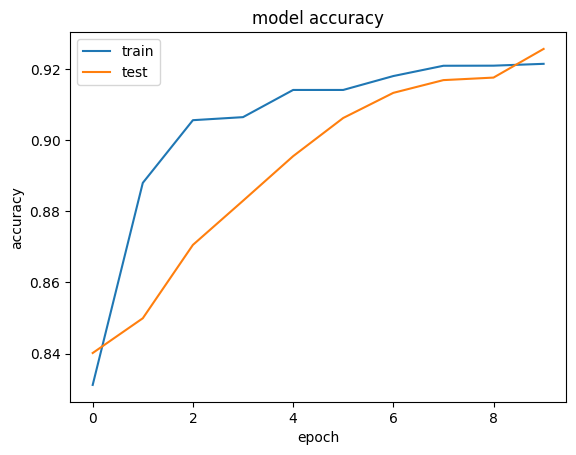

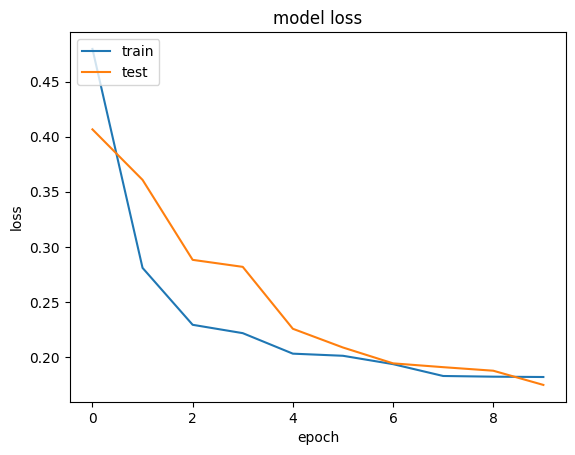

In [ ]:
# summarize history for accuracy
tacc=history.history['accuracy']
tacc.sort(reverse=False)
plt.plot(tacc)
tvalacc=history.history['val_accuracy']
tvalacc.sort(reverse=False)
plt.plot(tvalacc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
floss=history.history['loss']
floss. sort(reverse=True)
fvalloss=history.history['val_loss']
fvalloss. sort(reverse=True)
plt.plot(floss)
plt.plot(fvalloss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from PIL import Image
Dataset_add = '/content/gdrive/MyDrive/Database_Skin/'
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Database_Skin/Skin_Seg_New.h5')
Tr_add='Train_Seg/Malignant'
Tr_list = glob.glob(Dataset_add+ Tr_add+'/*.jpg')
for idx in range(len(Tr_list)):
    print(idx+1)
    img = Image.open(Tr_list[idx])
    img_1 = Image.open(Tr_list[idx])
    img = img.resize((height, width))
    b = Tr_list[idx]
    a = b[0:len(Dataset_add)]
    b = b[len(b)-16: len(b)-4]
    img = np.double(img.resize((height, width)))
    inpimg=img.astype(np.uint8)
    img = img
    predictions = model.predict(img.reshape(1,256,256,3), batch_size=1, verbose=1)
    scaled_image = (predictions * 255).astype(np.uint8)
    image = np.reshape(scaled_image, (height, width))
    _, binary_image = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img = img_1.resize((height, width))
    segmented_region = np.copy(img)
    Seg_Img=binary_image
    segmented_region[Seg_Img == 0] = 0
    segmented_image = Image.fromarray(segmented_region)
    segmented_image.save((a+ 'Train_Seg1/Malignant/' + b +'_Seg_img.png'))

1
1/1 [==============================] - 1s 919ms/step
2
1/1 [==============================] - 0s 26ms/step
3
1/1 [==============================] - 0s 28ms/step
4
1/1 [==============================] - 0s 41ms/step
5
1/1 [==============================] - 0s 48ms/step
6
1/1 [==============================] - 0s 28ms/step
7
1/1 [==============================] - 0s 32ms/step
8
1/1 [==============================] - 0s 40ms/step
9
1/1 [==============================] - 0s 29ms/step
10
1/1 [==============================] - 0s 27ms/step
11
1/1 [==============================] - 0s 22ms/step
12
1/1 [==============================] - 0s 33ms/step
13
1/1 [==============================] - 0s 27ms/step
14
1/1 [==============================] - 0s 24ms/step
15
1/1 [==============================] - 0s 28ms/step
16
1/1 [==============================] - 0s 24ms/step
17
1/1 [==============================] - 0s 37ms/step
18
1/1 [==============================] - 0s 40ms/step
19
1/1 [==========

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.models import Model
from sklearn.datasets import load_files
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K
train_path = "/content/gdrive/MyDrive/Database_Skin/Train_Seg1"
valid_path = "/content/gdrive/MyDrive/Database_Skin/Test_Seg1"
#Creating DataGenerator
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(256,256), classes =['Benign','Malignant'], batch_size=32)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(256,256), classes =['Benign','Malignant'], batch_size=32)
Xtrain = []
Ytrain = []
for i in range(len(train_batches)):
    batch_data, batch_labels = train_batches[i]
    Xtrain.extend(batch_data)
    Ytrain.extend(batch_labels)

Found 900 images belonging to 2 classes.
Found 381 images belonging to 2 classes.


In [ ]:
import numpy as np
Xtrain = np.array(Xtrain)
Ytrain = np.array(Ytrain)

In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D,LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # # Load the dataset
        # (X_train, y_train), (_, _) = mnist.load_data()
        # print(X_train.shape)
        X_train=Xtrain
        y_train=Ytrain
        print(X_train.shape)
        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        # X_train = np.expand_dims(X_train, axis=3)
        print(X_train.shape)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        # fig, axs = plt.subplots(r, c)
        # cnt = 0
        # for i in range(r):
        #     for j in range(c):
        #         axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
        #         axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
        #         axs[i,j].axis('off')
        #         cnt += 1
        # fig.savefig("images/%d.png" % epoch)
        # plt.close()

In [ ]:
cgan = CGAN()
cgan.train(epochs=25, batch_size=32, sample_interval=20)

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_122 (Dense)           (None, 512)               100663808 
                                                                 
 leaky_re_lu_115 (LeakyReLU)  (None, 512)              0         
                                                                 
 dense_123 (Dense)           (None, 512)               262656    
                                                                 
 leaky_re_lu_116 (LeakyReLU)  (None, 512)              0         
                                                                 
 dropout_32 (Dropout)        (None, 512)               0         
                                                                 
 dense_124 (Dense)           (None, 512)               262656    
                                                                 
 leaky_re_lu_117 (LeakyReLU)  (None, 512)            

In [ ]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
import tensorflow as tf
model = Sequential([
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dense(1664, activation='relu'),
    Dropout(0.5),
    Dense(1664, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])
model.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization_77 (Bat  (None, 62, 62, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 96)       0         
 2D)                                                             
                                                                 
 conv2d_32 (Conv2D)          (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_78 (Bat  (None, 30, 30, 256)      1024      
 chNormalization)                                                
                                                     

In [ ]:
from keras.callbacks import ReduceLROnPlateau
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(
    valid_batches,
    steps_per_epoch=None,
    epochs=50,
    validation_data=valid_batches,
    validation_steps=4,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_lr=0.00001)],
    shuffle=True)
model.save('/content/gdrive/MyDrive/Database_Skin/CGAN_Skin_Seg_New.h5')

Epoch 1/50
12/12 [==============================] - 11s 326ms/step - loss: 11.5020 - accuracy: 0.6325 - val_loss: 1532.9353 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - 2s 195ms/step - loss: 4.4077 - accuracy: 0.7008 - val_loss: 1181.9565 - val_accuracy: 0.6484 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - 3s 249ms/step - loss: 3.1364 - accuracy: 0.7717 - val_loss: 233.1710 - val_accuracy: 0.6641 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - 2s 172ms/step - loss: 2.4560 - accuracy: 0.7060 - val_loss: 40.6176 - val_accuracy: 0.7031 - lr: 0.0010
Epoch 5/50
12/12 [==============================] - 2s 177ms/step - loss: 2.5709 - accuracy: 0.7008 - val_loss: 60.4050 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 6/50
12/12 [==============================] - 2s 178ms/step - loss: 1.6764 - accuracy: 0.7559 - val_loss: 25.5380 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 7/50
12/12 [==============================] - 2s 17

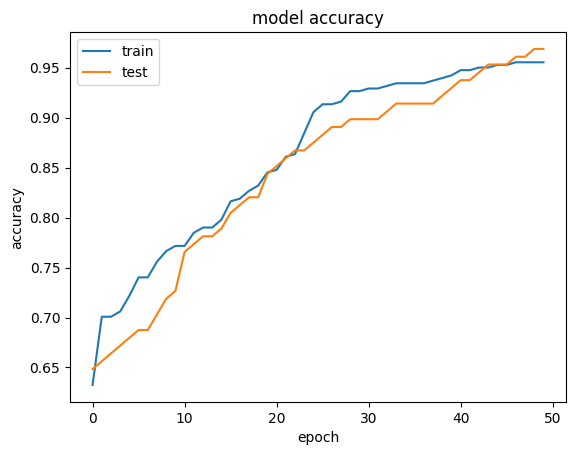

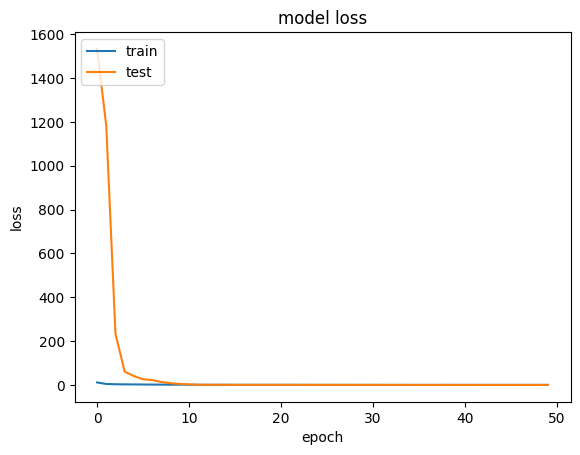

In [ ]:
# summarize history for accuracy
tacc=history.history['accuracy']
tacc.sort(reverse=False)
plt.plot(tacc)
tvalacc=history.history['val_accuracy']
tvalacc.sort(reverse=False)
plt.plot(tvalacc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
floss=history.history['loss']
floss. sort(reverse=True)
fvalloss=history.history['val_loss']
fvalloss. sort(reverse=True)
plt.plot(floss)
plt.plot(fvalloss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

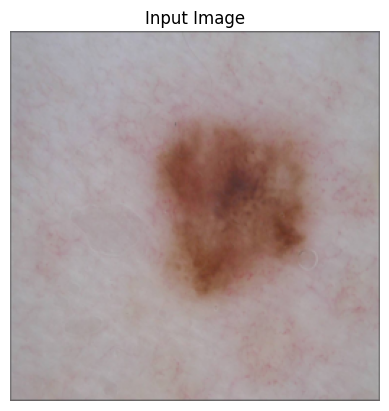

1/1 [==============================] - 1s 939ms/step


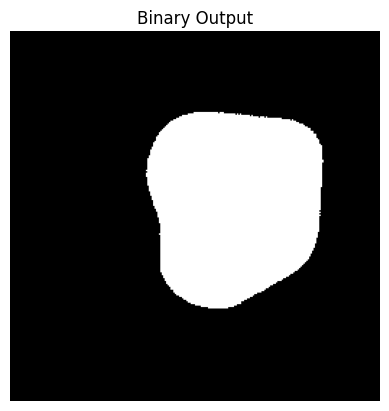

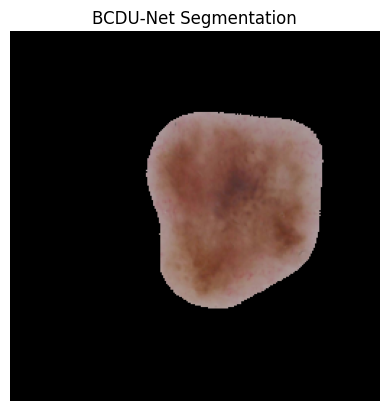

1/1 [==============================] - 0s 131ms/step
[[0.9886199  0.01138009]]


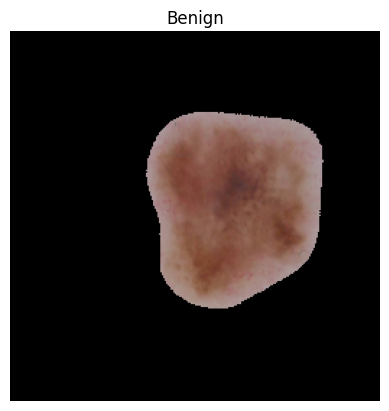

In [ ]:
import skimage.io as io
import skimage.transform as trans
from PIL import Image
import matplotlib.pyplot as plt
import cv2
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Database_Skin/Skin_Seg_New.h5')
test_path="/content/gdrive/MyDrive/Database_Skin/Test_Data/ISIC_0000023.jpg"
img_1 = Image.open(test_path)
img = Image.open(test_path)
img = np.double(img.resize((height, width)))
inpimg=img.astype(np.uint8)
plt.imshow(inpimg, cmap='gray')
plt.axis("off")
plt.title("Input Image")
plt.show()
img = img
# flag_multi_class = False
# target_size = (256,256)
# img = trans.resize(img,target_size)
# img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
# img = np.reshape(img,(1,)+img.shape)
predictions = model.predict(img.reshape(1,256,256,3), batch_size=1, verbose=1)
scaled_image = (predictions * 255).astype(np.uint8)
# predictions = np.where(scaled_image>0.1, 0, 1)
# print(predictions.shape)
image = np.reshape(scaled_image, (height, width))
_, binary_image = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# print(binary_image)
plt.imshow(binary_image, cmap='gray')
plt.axis("off")
plt.title("Binary Output")
plt.show()
img = img_1.resize((height, width))
segmented_region = np.copy(img)
Seg_Img=binary_image
segmented_region[Seg_Img == 0] = 0
plt.imshow(segmented_region, cmap='gray')
plt.axis("off")
plt.title("U-Net Segmentation")
plt.show()
segmented_image = Image.fromarray(segmented_region)
segmented_image.save('segmented_region.png')
image_path='/content/gdrive/MyDrive/segmented_region.png'
new_img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256,256))
img = tf.keras.preprocessing.image.img_to_array(new_img)
model_Gan = tf.keras.models.load_model('/content/gdrive/MyDrive/Database_Skin/CGAN_Skin_Seg_New.h5')
# img = tf.keras.preprocessing.image.img_to_array(segmented_region)
img = np.expand_dims(img, axis=0)
# img = img/255.0
prediction = model_Gan.predict(img)
print(prediction)
ypredict=np.argmax(prediction)
if ypredict==0:
  plt.imshow(new_img, cmap='gray')
  plt.axis("off")
  plt.title("Benign")
  plt.show()
else:
  plt.imshow(inpimg, cmap='gray')
  plt.axis("off")
  plt.title("Malignant")
  plt.show()
